# **Paddy Disease Classification **



## ***1.3 Dataset Overview:***

### *The competition provides a dataset containing images of paddy plants with various diseases. We will explore the dataset's size, features (e.g., image size, number of classes), and any preprocessing steps required (e.g., normalization, resizing) to prepare it for model training.*
### ***Dataset:*** [Paddy Doctor: Paddy Disease Classification](https://www.kaggle.com/competitions/paddy-disease-classification/overview)

## ***1.4 Specifics:***

### ***Model: EfficientNetB4***


# ***Import Libraries:***

In [1]:
import pandas as pd
import plotly.express as px
import gc
# import seaborn as sns
import tensorflow as tf
from keras.mixed_precision import set_global_policy
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, Dropout
from keras import regularizers, layers, models, Sequential
from keras.regularizers import l1
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications import EfficientNetB4
from keras.models import load_model
import os
import matplotlib.pyplot as plt
import random
# encode both columns label and variety
from sklearn.preprocessing import LabelEncoder
# ignore warnings   
import warnings
warnings.filterwarnings('ignore')

HOME_PATH = os.getcwd() + "/"

# ***Read csv file:***

In [2]:
# import meta_train.csv file

train_df = pd.read_csv(HOME_PATH + "meta_train.csv")
train_df.head()

image_id                  label variety  age
0  100330.jpg  bacterial_leaf_blight   ADT45   45
1  100365.jpg  bacterial_leaf_blight   ADT45   45
2  100382.jpg  bacterial_leaf_blight   ADT45   45
3  100632.jpg  bacterial_leaf_blight   ADT45   45
4  101918.jpg  bacterial_leaf_blight   ADT45   45

# ***Check `label` column:***

In [3]:
# Check the value counts of the label column
train_df['label'].value_counts()

label
normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: count, dtype: int64

In [4]:
# Check the number of unique values
train_df['label'].nunique()

10

# ***Rescaling:***

In [5]:
rescale = keras.layers.Rescaling(1./255)

# ***Load The Train Images And Test Images:***

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = keras.utils.image_dataset_from_directory(
    directory = HOME_PATH + 'train_images',
    batch_size = 16,
    image_size = (244, 244),
    validation_split=0.2,
    subset="training",
    seed=123  
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory=HOME_PATH + 'train_images',
    batch_size=16,
    image_size=(244, 244),
    validation_split=0.2,
    subset="validation",
    seed=123 
)


test_ds = keras.utils.image_dataset_from_directory(
    directory = HOME_PATH + 'test_images',
    batch_size = 16,
    image_size = (244, 244),
    label_mode = None,
    shuffle=False
)

# Apply rescaling
rescale = keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)
validation_ds = validation_ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x: rescale(x), num_parallel_calls=AUTOTUNE)

# Optimize data pipeline
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.
Found 10407 files belonging to 10 classes.
Using 2081 files for validation.
Found 3469 files.


# ***Data Visualisation:***

# *Scatter Plot using plotly:*

In [7]:
fig = px.scatter(train_df, x="age", y= "variety",color = "label")
fig.show()

# *Bar Plot using Plotly:*

In [8]:
fig = px.bar(train_df, x='label' , y='age', color='label')
fig.show()

# *Sunburst Using Plotly:*

In [9]:
# Create a sunburst plot
fig = px.sunburst(train_df, 
                  path=['label', 'variety'], 
                  values='age' , color='label')
# Show the plot
fig.show()

# ***Visualizing The Train Images:***

In [10]:
def visualize_images(path, num_images=5):

    # Get a list of image filenames
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    # Select random images
    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Display each image
    for i, image_filename in enumerate(selected_images):
        # Load image
        image_path = os.path.join(path, image_filename)
        image = plt.imread(image_path)

        # Display image
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


# ***bacterial_leaf_blight Images:***

In [11]:
# Specify the path containing the images to visualize
path_to_visualize = HOME_PATH + "/train_images/bacterial_leaf_blight"

# Visualize 5 random images
# visualize_images(path_to_visualize, num_images=5)

# ***bacterial_leaf_streak Images:***

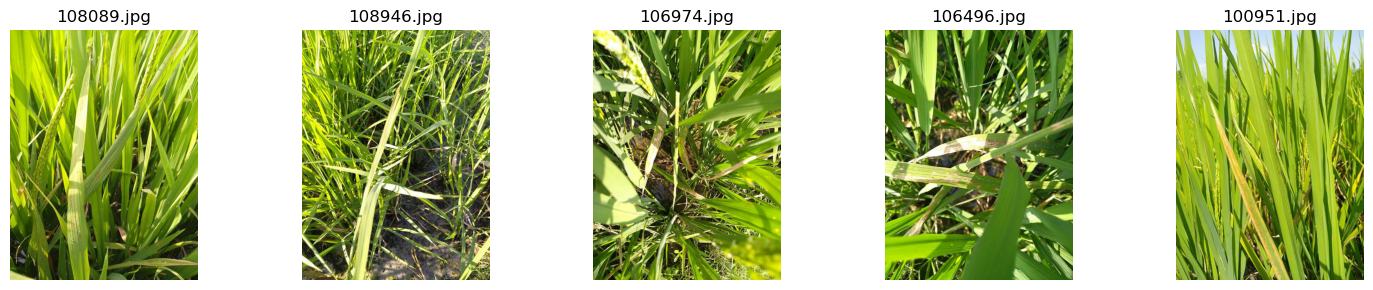

In [12]:
# Specify the path containing the images to visualize
path_to_visualize = HOME_PATH + "train_images/bacterial_leaf_streak"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

# ***bacterial_panicle_blight Images:***

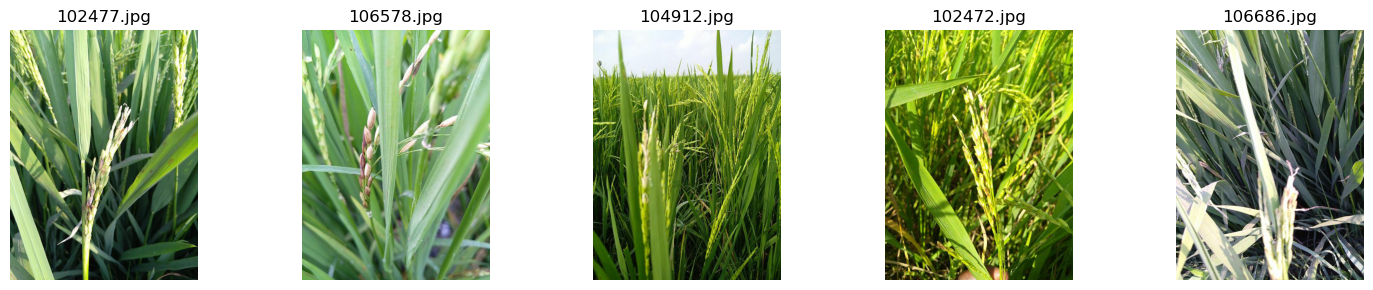

In [13]:
# Specify the path containing the images to visualize
path_to_visualize = HOME_PATH + "/train_images/bacterial_panicle_blight"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

# ***blast Images:***

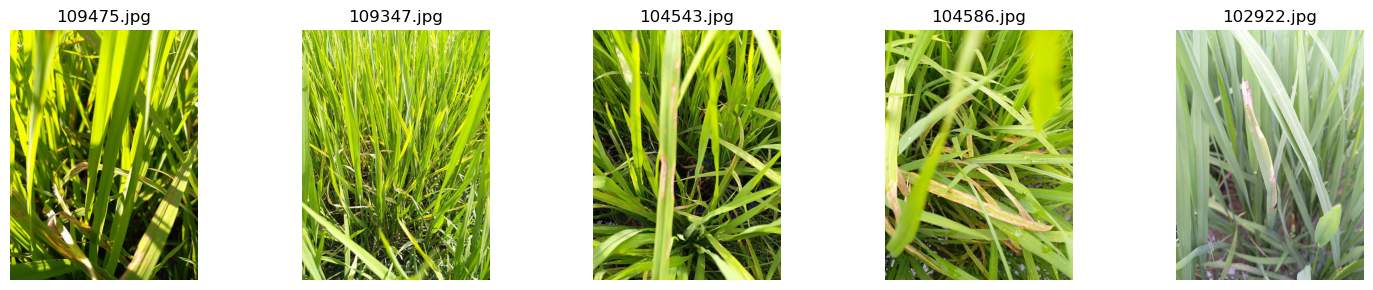

In [14]:
# Specify the path containing the images to visualize
path_to_visualize = HOME_PATH + "/train_images/blast"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

# ***brown_spot Images:***

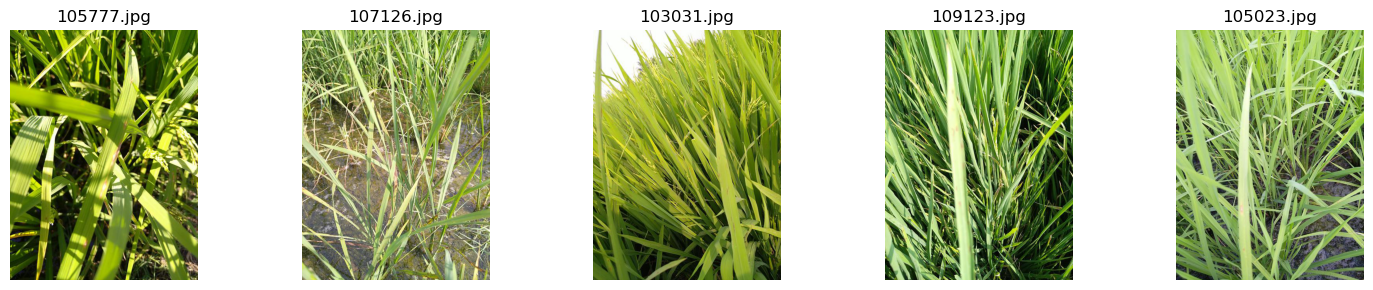

In [15]:
# Specify the path containing the images to visualize
path_to_visualize = HOME_PATH + "/train_images/brown_spot"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

# ***dead_heart Images:***

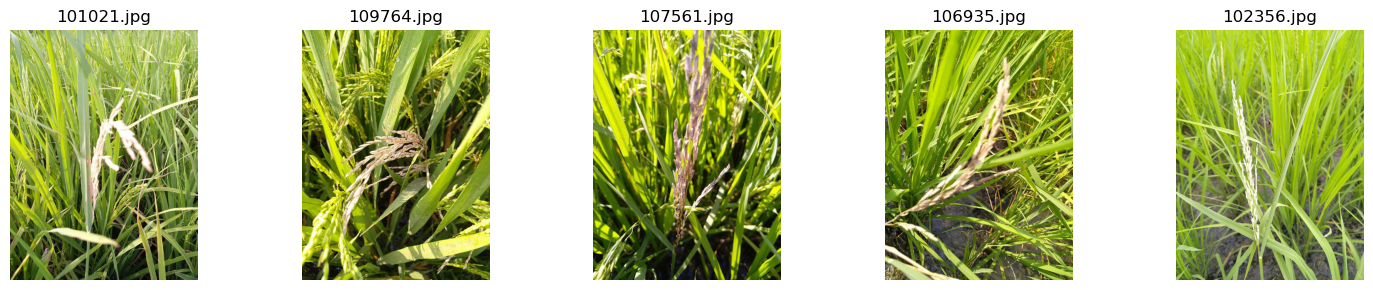

In [16]:
# Specify the path containing the images to visualize
path_to_visualize = HOME_PATH + "/train_images/dead_heart"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

# ***downy_mildew Images:***

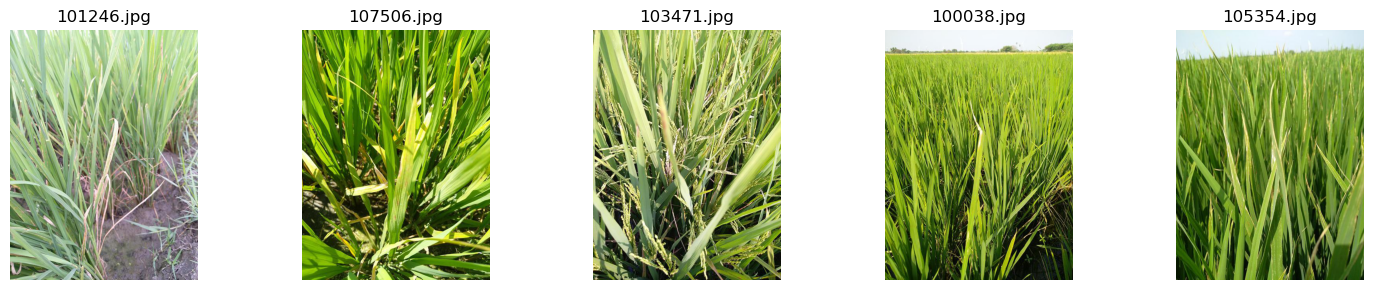

In [17]:
# Specify the path containing the images to visualize
path_to_visualize = HOME_PATH + "/train_images/downy_mildew"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

# ***hispa Images:***

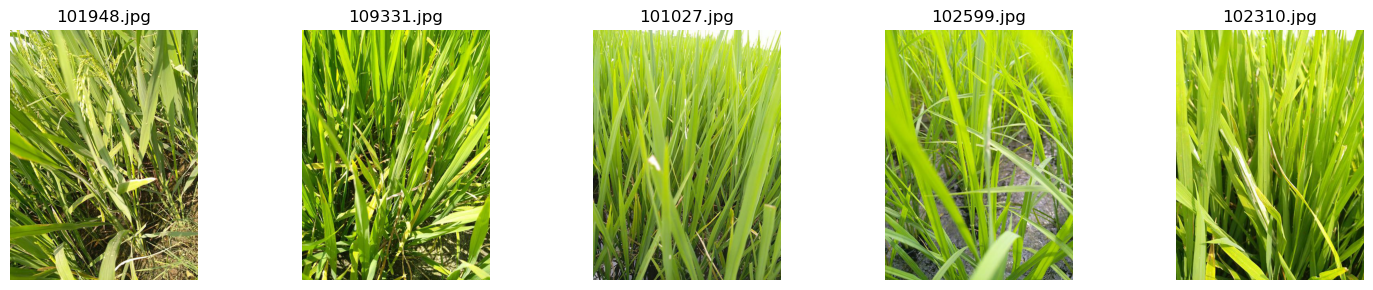

In [18]:
# Specify the path containing the images to visualize
path_to_visualize = HOME_PATH + "/train_images/hispa"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

# ***normal Images:***

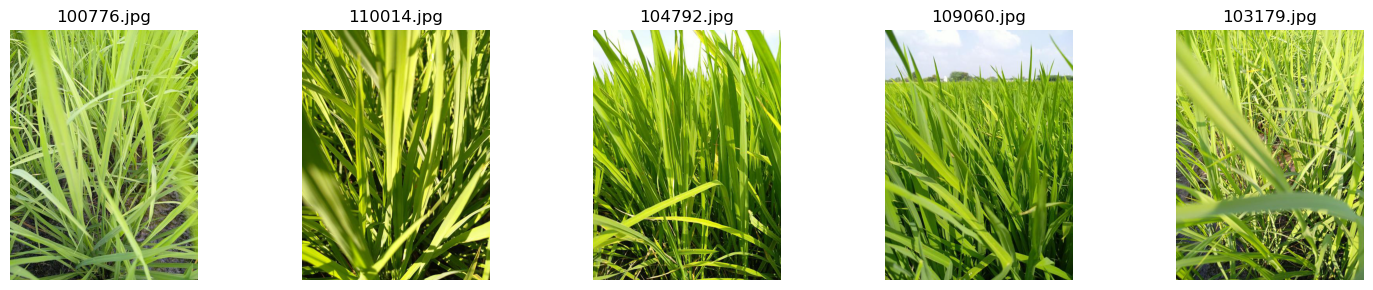

In [19]:
# Specify the path containing the images to visualize
path_to_visualize = HOME_PATH + "/train_images/normal"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

# ***tungro Images:***

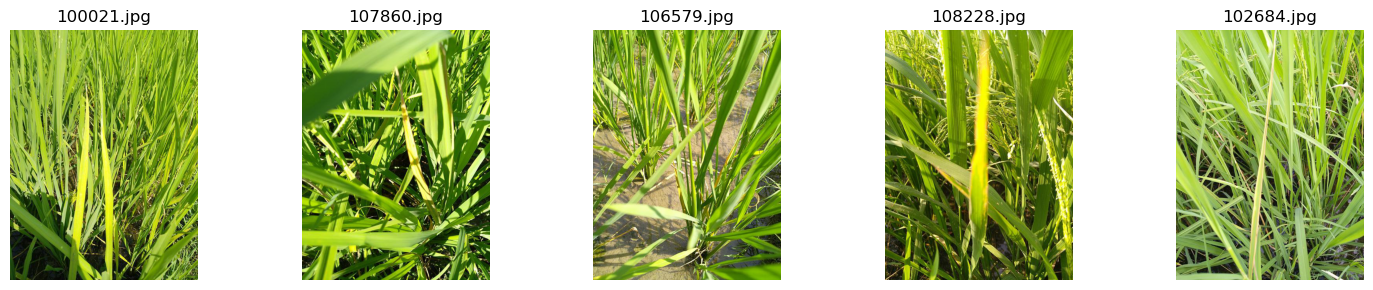

In [20]:
# Specify the path containing the images to visualize
path_to_visualize = HOME_PATH + "/train_images/tungro"

# Visualize 5 random images
visualize_images(path_to_visualize, num_images=5)

# ***Autotune The Data:***

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ***Model Building:***

# *Transfer Learning:*

In [22]:
# Load the pre-trained EfficientNetB4 model without the top classification layer
base_model = keras.applications.EfficientNetB4(
    weights=None, 
    include_top=False, 
    input_shape=(244, 244, 3)
)

# Freeze the pre-trained base model layers
base_model.trainable = True

In [23]:
from keras.models import Sequential
# Build the model
model = Sequential()

# Add the pre-trained Xception base
model.add(base_model)

# Add global average pooling layer to reduce spatial dimensions
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# Flatten the feature maps
model.add(Flatten())

# Add a dense layer with 120 units and ReLU activation function
model.add(Dense(220, activation='relu'))

# Dropout Layer
model.add(Dropout(0.25)) 

# Add the output layer with 1 unit and sigmoid activation function for binary classification
model.add(Dense(10, activation='softmax'))

## ***Check The Summary Of Model:***

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 8, 8, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 4, 4, 1792)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28672)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 220)            │     6,308,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 220)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,984,093 (91.49 MB)

 Trainable params: 23,858,886 (91.01 MB)

 Non-trainable params: 125,207 (489.09 KB)

# ***Compile the Model:***

In [25]:
keras.backend.clear_session()
gc.collect()

set_global_policy('mixed_float16')

# Define data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


inputs = keras.Input(shape=(244, 244, 3))
x = data_augmentation(inputs)
x = base_model(x, training=True)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  # Giảm từ 220 xuống 128
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(10, activation='softmax', dtype='float32')(x)
model = keras.Model(inputs, outputs)

base_learning_rate = 0.001
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ***Model Training:***

In [ ]:
%%time

# Clear session and memory
keras.backend.clear_session()
gc.collect()

# Define the callback functions
early_stopping = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

class PrintValMetrics(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}: val_loss = {logs['val_loss']:.4f}, val_accuracy = {logs['val_accuracy']:.4f}")

# Clear memory before training
gc.collect()


history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=100,
    callbacks=[early_stopping, checkpoint, reduce_lr, PrintValMetrics()]
)

keras.backend.clear_session()
gc.collect()

Epoch 1/100
 79/521 ━━━━━━━━━━━━━━━━━━━━ 23:14 3s/step - accuracy: 0.1474 - loss: 6.7257

# ***Plotting The Loss And Accuracy:***

In [ ]:
model = models.load_model('best_model.keras')

# Plotting the training and testing loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('loss_plot.png')
plt.show()

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('accuracy_plot.png')
plt.show()

# ***Predictions:***

In [ ]:
# Predict the labels of the test set
predictions = model.predict(test_ds)

# Assuming label_names contains the class names in the correct order
labels = ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

predicted_labels = [labels[prediction.argmax()] for prediction in predictions]

loss, accuracy = model.evaluate(validation_ds)
print(f'Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}')
loss = model.evaluate(validation_ds)
print(f'Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}')


In [ ]:
# Create a submission file
submission_df = pd.DataFrame({'image_id': test_ds.file_paths, 'label': predicted_labels})

submission_df['image_id'] = submission_df['image_id'].apply(lambda x: x.split('/')[-1])

submission_df.to_csv('sample_submission.csv', index=False)

In [ ]:
# Display unique predicted labels
print(set(predicted_labels))

# Display submission head
print(submission_df.head())